1. Mengimport semua library yang diperlukan

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import keras as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

2. Mengambil data dari direktori local

In [2]:

base_ds = 'C:\\Users\\Gesang\\Desktop\\Dataset Beras\\Campuran'
sample_img1 = cv2.imread('C:\\Users\\Gesang\\Desktop\\Dataset Beras\\Flashlight\\Pulen\\IMG20221129091354.jpg')
print(sample_img1.shape)

target_size = (480,480)
input_shape = (480,480,3)
batch_size = 8

(3120, 4160, 3)


3. Pembagian Data Train, Validation dan Test menggunakan ImageDataGenerator serta melakukan preprocessing data yaitu horizontal_flip, vertical_flip, rotation_range, fill_mode dan mengubah size dari citra.

In [3]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
validation_split=0.2,
rotation_range=45,
width_shift_range=0.25,
shear_range=0.25,
zoom_range=0.25,
horizontal_flip=True,
vertical_flip=True,
fill_mode='nearest'
)

train_ds = train_datagen.flow_from_directory(
    base_ds,
    target_size=target_size,
    shuffle=True,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
)

valid_ds = train_datagen.flow_from_directory(
    base_ds,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1248 images belonging to 2 classes.
Found 312 images belonging to 2 classes.


4. Melakukan transfer learning menggunakan InceptionV3 dengan arsitektur 'imagenet'. Mengatur layers pada pretrained model menjadi false. Lalu memberikan 1 hidden layer tambahan dan fungsi aktivasi berupa relu dan sigmoid, dropout layer dan output layer yaitu Dense 1

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False
    
early_stop=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=2, verbose=1, restore_best_weights=True)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,  patience=5, verbose=1,min_lr=0.0001)

In [5]:

x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(2, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

5. Membuat Callback untuk memastikan model selesai melakukan training saat mencapai akurasi tinggi dan loss rendah. Dilakukan untuk menghindari overfitting. Membuat ModelCheckpoint untuk menyimpan model yang terbaik.

In [6]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get("accuracy")>=0.95 and logs.get("loss")<=2):
           print("\nReached 90%+ accuracy so canelling training!")
           self.model.stop_training = True
           model.save("./saved_models_10")

In [7]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='saved_models_10/model_inceptionV3_10.h5', 
                               monitor='loss', mode='min',
                               verbose=1, save_best_only=True, save_weights_only=False)

6. Melakukan proses training dengan 50 epoch.

In [8]:
history = model.fit(train_ds,
                    validation_data=valid_ds,
                    steps_per_epoch=train_ds.samples/batch_size,
                    validation_steps=None,
                    epochs=50,
                    verbose=1,
                    callbacks=[myCallback(), rlronp])

Epoch 1/50
156/156 [==============================] - 606s 4s/step - loss: 21.6194 - accuracy: 0.8470 - val_loss: 21.7391 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/50
156/156 [==============================] - 618s 4s/step - loss: 4.2028 - accuracy: 0.9127 - val_loss: 6.8516 - val_accuracy: 0.7404 - lr: 0.0010
Epoch 3/50
156/156 [==============================] - 628s 4s/step - loss: 1.0596 - accuracy: 0.9319 - val_loss: 0.6427 - val_accuracy: 0.8526 - lr: 0.0010
Epoch 4/50
156/156 [==============================] - 622s 4s/step - loss: 0.2188 - accuracy: 0.9407 - val_loss: 0.4154 - val_accuracy: 0.8654 - lr: 0.0010
Epoch 5/50
156/156 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.9575
Reached 90%+ accuracy so canelling training!


INFO:tensorflow:Assets written to: ./saved_models_10\assets


INFO:tensorflow:Assets written to: ./saved_models_10\assets


156/156 [==============================] - 649s 4s/step - loss: 0.1229 - accuracy: 0.9575 - val_loss: 0.2822 - val_accuracy: 0.8782 - lr: 0.0010


7. Melakukan visualisasi dari training berupa akurasi, val akurasi, loss, dan val loss.

[0.8469551205635071, 0.9126602411270142, 0.9318910241127014, 0.9407051205635071, 0.9575320482254028]


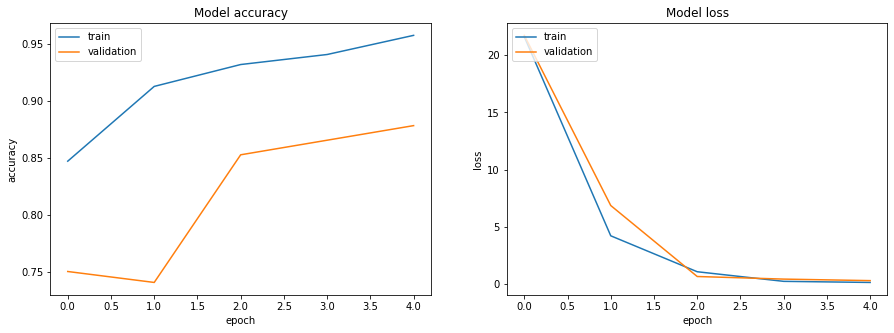

In [9]:
print(history.history['accuracy'])
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_train_history(history)

8. Mengambil model yang sudah di simpan menggunakan load_model dengan pathnya.

In [11]:
saved_model_path= "C:\\Users\\Gesang\\Documents\\SMT 7\\Prak ML\\Portofolio\\saved_models_10"
loaded_model= tf.keras.models.load_model(saved_model_path)

9. Membuat test datagen untuk melakukan testing dari model yang sudah di load.

In [12]:
test_base = 'C:\\Users\\Gesang\\Desktop\\Dataset Beras\\Test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    test_base,
    target_size=target_size,
    # batch_size=batch_size,
    class_mode='binary'
)

Found 10 images belonging to 2 classes.


10. Evaluasi model menggunakan model.evaluate dengan test_ds.

In [23]:
predictions = loaded_model.predict(test_ds,verbose=1)
confussion_matrix(

1/1 [==============================] - 3s 3s/step


11. Confussion Matrix pada testing

In [35]:
from sklearn.metrics import confusion_matrix

labels=test_ds.labels
y_pred=[]
predictions = loaded_model.predict(test_ds, verbose=1)
for i in predictions:
    y_pred.append(np.argmax(i))
    
y_true=np.array(labels)
print(y_true)
y_pred=np.array(y_pred)
print(y_pred)
cm=confusion_matrix(y_true, y_pred)
print(cm)

1/1 [==============================] - 3s 3s/step
[0 0 0 0 0 1 1 1 1 1]
[1 0 0 0 0 1 0 1 1 1]
[[4 1]
 [1 4]]


In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10



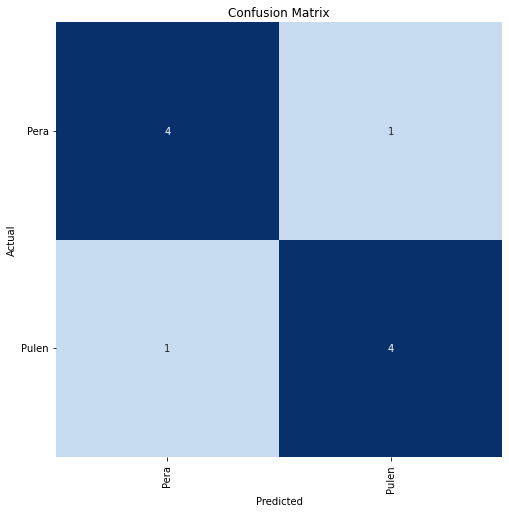

In [36]:
import seaborn as sns
length=2 # two classes
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
classes=list(test_ds.class_indices.keys())
plt.xticks(np.arange(length)+.5, classes, rotation= 90)
plt.yticks(np.arange(length)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

12. Melakukan pre-proses data untuk melakukan prediksi satu per satu sepertihalnya nanti akan dilakukan pada aplikasi android

In [14]:
from PIL import Image
import numpy as np
from skimage import transform

In [15]:
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (480, 480, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

In [16]:
image = load('C:\\Users\\Gesang\\Desktop\\Dataset Beras\\Test\\Pera\\IMG20221215140845.jpg')

In [17]:
predict = model.predict(image)
print(predict)

1/1 [==============================] - 2s 2s/step
[[0.98702765 0.01297234]]


In [18]:
import os

os.chdir('C:\\Users\\Gesang\\Desktop\\Dataset Beras\\Test\\Pera')

for f in os.listdir():
    file_name, file_ext = os.path.splitext(f)
    if file_ext == '.jpg':
        images = file_name
        image = load(f'C:\\Users\\Gesang\\Desktop\\Dataset Beras\\Test\\Pera\\{images}.jpg')
        predict = model.predict(image)
        predict_labels =  np.where(predict > 0.5,1,0)
        print(predict_labels)
print("\n\n")
os.chdir('C:\\Users\\Gesang\\Desktop\\Dataset Beras\\Test\\Pulen')
for f in os.listdir():
    file_name, file_ext = os.path.splitext(f)
    if file_ext == '.jpg':
        images = file_name
        image = load(f'C:\\Users\\Gesang\\Desktop\\Dataset Beras\\Test\\Pulen\\{images}.jpg')
        predict1 = model.predict(image)
        predict_labels =  np.where(predict1 > 0.5,1,0)
        print(predict_labels)

1/1 [==============================] - 0s 345ms/step
[[1 0]]
1/1 [==============================] - 0s 359ms/step
[[1 0]]
1/1 [==============================] - 0s 357ms/step
[[1 0]]
1/1 [==============================] - 0s 344ms/step
[[1 0]]
1/1 [==============================] - 0s 450ms/step
[[1 0]]



1/1 [==============================] - 0s 342ms/step
[[0 1]]
1/1 [==============================] - 0s 349ms/step
[[0 1]]
1/1 [==============================] - 0s 361ms/step
[[0 1]]
1/1 [==============================] - 0s 395ms/step
[[0 1]]
1/1 [==============================] - 0s 347ms/step
[[0 1]]


Hasil output yang didapatkan dari model dengan pre-trained model Inception sudah dapat dibilang bagus. 